In [14]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from Pachaches.functions import clean_PM25frame_coloumns
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [16]:
chem=pd.read_excel(r"\\192.168.1.59\UserFolders\michael.forsmann\Data_library\Carbonyl_NOX_NYT_SKEMA\070511_CarbNOx_FINAL_mean_051111.xls")

In [19]:
chem=clean_PM25frame_coloumns(chem)
chem=chem.replace(",",".",regex=True).rename(columns={"no2_(μg/m3)":"no2","no_(μg/m3)":"Nox","formald_(μg/m3)":"formaldehyd","acetald_(μg/m3)":"acetald","acetone_(μg/m3)":"acetone"})

In [21]:
sample_time=((chem["stop_c"]-chem["start_c"]).dropna().to_numpy()*10**(-9)/(60*60*24*7)).astype(float)
chem_2=chem.loc[chem["stop_c"].isna()==0,:].assign(sample_time=sample_time)
chem_2["stop_c"].loc[sample_time>40]=(chem_2.loc[sample_time>40]["stop_c"]+pd.offsets.DateOffset(years=1))
chem_2["stop_c"].loc[sample_time<0]=(chem_2.loc[sample_time<0]["stop_c"]+pd.offsets.DateOffset(years=1))
sample_time=((chem_2["stop_c"]-chem_2["start_c"]).to_numpy()*10**(-9)/(60*60*24)).astype("float")
chem_2=chem_2.assign(sample_time=sample_time)
chem_2.no2=chem_2.no2.astype(float)
chem_2.sample_time=chem_2.sample_time/7

C:\Users\michael.forsmann\AppData\Local\Temp\ipykernel_1028\3208450535.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  chem_2["stop_c"].loc[sample_time>40]=(chem_2.loc[sample_time>40]["stop_c"]+pd.offsets.DateOffset(years=1))
C:\Users\mi

In [39]:
chem_2.to_excel("chemical_updated.xlsx")

In [23]:
correction=chem_2.drop(['Nox', 'formaldehyd', 'acetald', 'acetone','cpnr', 'visit', 'batch_c', 'start_c', 'stop_c', 'batch_n', 'start_n',
       'stop_n'],axis=1).loc[chem_2.no2.isna()==0]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(correction, correction.no2, test_size = 0.3)

In [27]:
exp_curve=curve_fit(lambda t,a,b: a*np.exp(b*t),  X_train.sample_time,y_train)
linear_curve=curve_fit(lambda t,a,b: a * np.sqrt(t) +b,  X_train.sample_time,y_train)
log_curve=curve_fit(lambda t,a,b:np.log( a * t) +b,  X_train.sample_time,y_train)

C:\Users\michael.forsmann\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [29]:
def exp(x, a, b):
    return a * np.exp(b * x)
def linear(x, a, b):
    return a * np.sqrt(x) +b

In [31]:
linear_curve_No2=curve_fit(lambda t,a,b: a * np.sqrt(t) +b,  X_train.sample_time,y_train)


In [33]:
rmse_exp=np.sqrt(np.mean((exp(X_test.sample_time,*exp_curve[0])-y_test)**2))
rmse_linear=np.sqrt(np.mean((linear(X_test.sample_time,*linear_curve[0])-y_test)**2))
rmse_log=np.sqrt(np.mean((linear(X_test.sample_time,*log_curve[0])-y_test)**2))
rmse_exp,rmse_linear,rmse_log

(4.943946487640152, 4.94465927742176, 21.742000250748426)

In [35]:
linear_curve

(array([-1.0270132 , 11.94667993]),
 array([[ 0.36959088, -1.18749113],
        [-1.18749113,  3.84847386]]))

In [37]:
r2_exp=r2_score(y_test,exp(X_test.sample_time,*exp_curve[0]))
r2_linear=r2_score(y_test,linear(X_test.sample_time,*linear_curve[0]))
r2_log=r2_score(y_test,linear(X_test.sample_time,*log_curve[0]))
r2_exp,r2_linear,r2_log

(0.0016208344079402526, 0.001332932518683383, -18.308430778858675)

In [136]:
chem_2["no2_corrected_exp"]=exp(10,*exp_curve[0])/exp(chem_2.sample_time,*exp_curve[0])*chem_2.no2
chem_2["no2_corrected_linear"]=linear(10,*linear_curve[0])/linear(chem_2.sample_time,*linear_curve[0])*chem_2.no2

In [138]:
x=np.linspace(5,21,100)

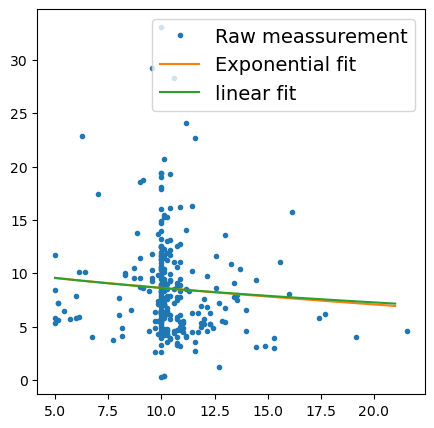

In [140]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(X_test.sample_time,y_test,'.',label="Raw meassurement")
ax.plot(x,exp(x,*exp_curve[0]),label="Exponential fit")
ax.plot(x,linear(x,*linear_curve[0]),label="linear fit")
ax.legend(fontsize=14)


C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\michael.forsmann\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


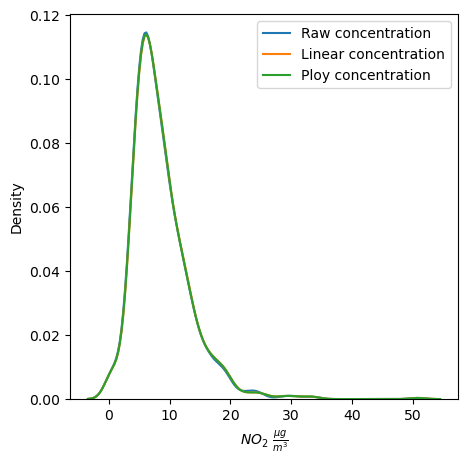

In [142]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
sns.kdeplot(chem_2["no2"],ax=ax,label="Raw concentration")
sns.kdeplot(chem_2["no2_corrected_exp"],ax=ax,label="Linear concentration")
sns.kdeplot(chem_2["no2_corrected_linear"],ax=ax,label="Ploy concentration")
ax.set_xlabel(r"$NO_2 \ \frac{\mu g}{m^3} $")
ax.legend()
fig.savefig("distribution_corrections.png")